We start by attempting a boosting model. LightGBM handles imbalanced classes and categorical/continuous variables relatvely well. 

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import numpy as np
from sklearn import preprocessing
import pickle
from sklearn.model_selection import StratifiedShuffleSplit

In [40]:
#Load the data 
with open('test_set.pkl', 'rb') as f:
        X_test= pickle.load(f)  
with open('train_set.pkl', 'rb') as f:
        X_train= pickle.load(f)  
with open('ytest.pkl', 'rb') as f:
        y_test= pickle.load(f)  
with open('ytrain.pkl', 'rb') as f:
        y_train= pickle.load(f)  
for i in [X_train,X_test]:
    i.pop("artist_has_award")


In [41]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
#lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

#can replace 'is_unbalance': 'true', by 'scale_pos_weight': 10,

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'boosting': 'gbdt',
    'is_unbalance': 'true',
    'num_leaves': 25,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

model = lgb.train(parameters,
                       lgb_train,
                       valid_sets=lgb_train,
                       num_boost_round=100,
                       early_stopping_rounds=100)

predictions = model.predict(X_test)


[1]	training's auc: 0.643692
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.711374
[3]	training's auc: 0.75586
[4]	training's auc: 0.769595
[5]	training's auc: 0.780106
[6]	training's auc: 0.789227
[7]	training's auc: 0.800747
[8]	training's auc: 0.805211
[9]	training's auc: 0.806446
[10]	training's auc: 0.811684
[11]	training's auc: 0.819147
[12]	training's auc: 0.820416
[13]	training's auc: 0.8233
[14]	training's auc: 0.825859
[15]	training's auc: 0.832436
[16]	training's auc: 0.83428
[17]	training's auc: 0.837645
[18]	training's auc: 0.837637
[19]	training's auc: 0.838567
[20]	training's auc: 0.840964
[21]	training's auc: 0.843941
[22]	training's auc: 0.847539
[23]	training's auc: 0.850622
[24]	training's auc: 0.852603
[25]	training's auc: 0.8535
[26]	training's auc: 0.855354
[27]	training's auc: 0.856863
[28]	training's auc: 0.857809
[29]	training's auc: 0.8586
[30]	training's auc: 0.86013
[31]	training's auc: 0.86127
[32]	training's auc: 0.8626

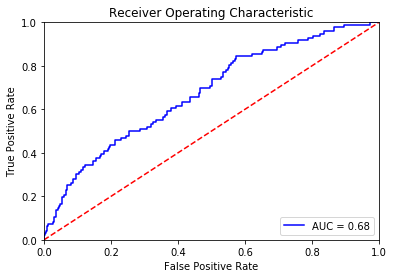

In [42]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

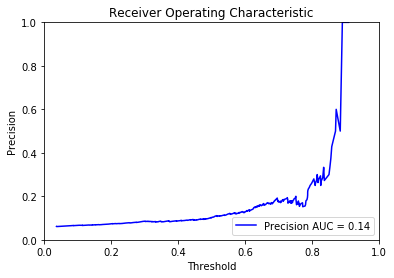

In [43]:

from sklearn.metrics import precision_recall_curve
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test,predictions)
# calculate precision-recall AUC
precision_auc = metrics.auc(recall, precision)

plt.title('Receiver Operating Characteristic')
plt.plot(thresholds, precision[:len(precision)-1], 'b', label = 'Precision AUC = %0.2f' % precision_auc)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Threshold')
plt.show()

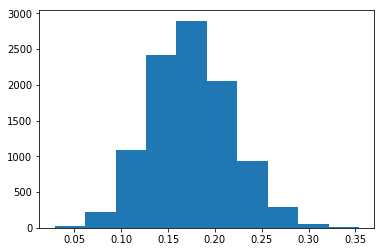

95.0 confidence interval 9.5% and 26.4%


In [45]:
from sklearn.utils import resample
df = X_test.copy()
df["top10"] = y_test.values
stats1 = list()
for i in range(10000):
    boot = resample(df, replace=True, n_samples=1000)
    boot_y = boot.pop("top10")
    boot_pred = model.predict(boot)
    predictions_matrix = [1 if pred > 0.70 else 0 for pred in boot_pred]
    precision = (confusion_matrix(boot_y,predictions_matrix)[1][1]) / (confusion_matrix(boot_y,predictions_matrix)[1][1] + confusion_matrix(boot_y,predictions_matrix)[0][1]) 
    stats1.append(precision)
    
# plot scores
plt.hist(stats1)
plt.show()
# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower1 = max(0.0, np.percentile(stats1, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper1 = min(1.0, np.percentile(stats1, p))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower1*100, upper1*100))

In [44]:
# Record the feature importances
feature_importances = model.feature_importance()
for i in range(len(feature_importances)):
    print(feature_importances[i],X_train.columns[i])

19 spotify_explicit
143 spotify_duration_ms
78 spotify_track_number
168 spotify_danceability
172 spotify_energy
173 spotify_loudness
21 spotify_mode
151 spotify_speechiness
193 spotify_acousticness
87 spotify_instrumentalness
112 spotify_liveness
131 spotify_valence
140 spotify_tempo
9 spotify_time_signature
24 num_artists
76 award_num
74 gold_count
58 platinum_count
68 num_songs_awards
132 firstrank
37 label_category_group
16 album_type
118 datetime_year
35 datetime_month
106 numberofappearances_artist
59 numberofappearances_artist_top10
